In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import time
import math

In [3]:
#clean dataset

dataset = pd.read_csv('MSFT.csv')
dataset = dataset.dropna()

#only use close price
dataset = dataset.iloc[:,4:5].values
#normalize
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dataset = sc.fit_transform(dataset)

#split into train and test, firts 80% for train, last 20% for test
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#convert to tensor for batch processing
train_tensor = torch.FloatTensor(train)
test_tensor = torch.FloatTensor(test)

'''#reshape tensor to (1,batchsize,length/batchsize)
batchsize = 6
numero_batches = int(train.shape[0]/batchsize)
print(numero_batches)
train_tensor = train.view((1,int(train.shape[0]/batchsize),batchsize))
print(train_tensor)
print(train_tensor.shape)'''

#test = test.view((1,batchsize,int(test.shape[0]/batchsize)))
#test.shape
#train.shape
print(train_tensor.shape)
print(train_tensor[55])
#print(train[:,:,-1].shape)






#dataset[:10]


torch.Size([7266, 1])
tensor([8.0981e-05])


In [4]:


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size) 
        self.in2output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1) #en la primera pasada se inicializará hidden para rellenar ese espacio
        hidden = torch.sigmoid(self.in2hidden(combined))
        output = self.in2output(hidden)
        return output, hidden
    
    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))
    
#trainig por epoca recorriendo todos los valores
def train(input_tensor, criterion, optimizer,model,k,predict):
    hidden = model.init_hidden()    #al inicio de cada epoca se inicializa el hidden state en 0
    
    optimizer.zero_grad()
    loss = 0
    if predict==False:
        for value in range(input_tensor.size(0)-1):   #we iterate over all values
            target_tensor= input_tensor[value+1] #
            output, hidden = model(input_tensor[value].unsqueeze(0) , hidden) 
            
            loss += criterion(output, target_tensor.unsqueeze(0))

            if (value +1)%k==0:#we optimize until we reach k deepth in our network
                loss_para_return=loss.item() / k
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                hidden = hidden.detach()
                loss = 0
    else:
        lista_output=[]
        for value in range(input_tensor.size(0)-1):
            output, hidden = model(input_tensor[value].unsqueeze(0) , hidden) 
            if (value +1)%5==0:
                output_para_return=output.detach().numpy()
                lista_output.append(output_para_return)
                hidden_para_return=hidden
                loss_para_return=0
        output=lista_output

        
    return output, loss_para_return



#training
def trainEpoch(input_tensor, epochs, criterion, optimizer,model,k,predict=False):
    start = time.time()
    print_every = 1
    plot_every = 1
    all_losses = []
    total_loss = 0 # Reset every plot_every iters
    
    for epoch in range(1, epochs + 1):
        output, loss = train(input_tensor, criterion, optimizer,model,k,predict)
        total_loss += loss
        if epoch % print_every == 0:
            print('%s (%d %d%%) %.7f' % (timeSince(start), epoch, epoch / epochs * 100, loss))
        if epoch % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
    return all_losses

In [5]:
#training
epochs = 10
hidden_size = 1
lr=0.1

# Define input and target tensors
input_tensor = train_tensor

input_size = 1
output_size = 1

# Define Model
model= RNN(input_size, hidden_size, output_size)

# Define Loss, Optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
k=200 #batch size o truncation length
all_losses = trainEpoch(input_tensor, epochs, criterion, optimizer,model,k,predict=False)


0m 2s (1 10%) 0.0013238
0m 4s (2 20%) 0.0006042
0m 6s (3 30%) 0.0003910
0m 8s (4 40%) 0.0004712
0m 10s (5 50%) 0.0009961
0m 12s (6 60%) 0.0017599
0m 14s (7 70%) 0.0021752
0m 16s (8 80%) 0.0021868
0m 18s (9 90%) 0.0020097
0m 20s (10 100%) 0.0016641


[0.0013237908482551576, 0.0006042378023266793, 0.0003910007327795029, 0.0004711998626589775, 0.0009961368143558502, 0.0017598931491374968, 0.0021751980483531953, 0.0021867655217647553, 0.0020097473263740537, 0.001664137840270996]


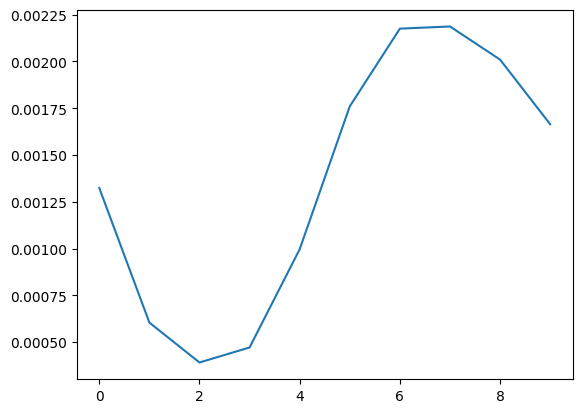

In [6]:
print(all_losses)

# Plot the losses
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)
plt.show()


7266


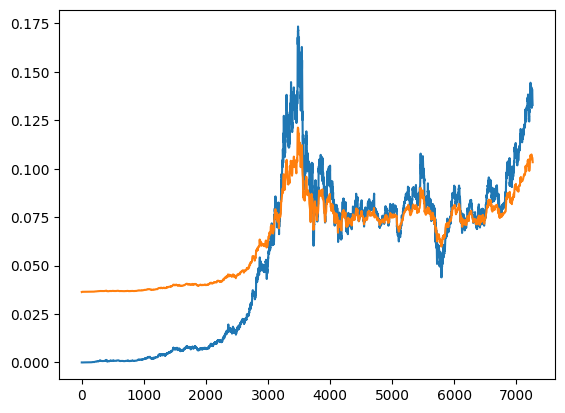

In [16]:
#plot de valores reales vs valores predichos
# Define input and target tensors


#prediccion de valores usando el modelo ya entrenado
# Define input and target tensors
input_tensor = train_tensor
output, loss = train(input_tensor, criterion, optimizer,model,k,predict=True)
output=np.array(output)
output=output.reshape(-1,1)
#print(output)
#plot de valores reales vs valores predichos
# Define input and target tensors
size=train_tensor.size(0)
num=output.size#int(size/k)
print(size)
t_output=np.linspace(0,size,num)
plt.plot(train_tensor)
plt.plot(t_output,output)
plt.show()



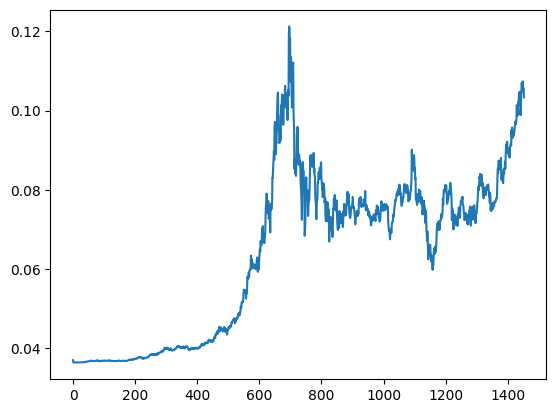

In [8]:

#plt.axis([0, 7000, 0, 0.175])
